In [ ]:
from infrastructure.classes import Experiment, TrainParameters
from infrastructure.training import train

import torch
experiment = Experiment(
    tensor_parameters=dict(dtype=torch.float32, device=torch.device("cpu")),
    dataset_name="fnlvqr_star",
    dataset_number_of_points=10**4,
    dataset_parameters=dict(),
    dataloader_parameters=dict(batch_size=32, shuffle=True),
    pushforward_operator_name="amortized_neural_quantile_regression",
    pushforward_operator_parameters=dict(
        feature_dimension=1,
        response_dimension=2,
        hidden_dimension=16,
        number_of_hidden_layers=2,
        potential_to_estimate_with_neural_network="u",
    ),
    train_parameters=TrainParameters(
        number_of_epochs_to_train=100,
        verbose=True,
        optimizer_parameters=dict(lr=0.01),
        scheduler_parameters=dict(eta_min=0)
    )
)

model = train(experiment)
_ = model.eval()

Epoch: 100, Potential Objective: 1.791, Amortization Objective: 0.101, LR: 0.010000: 100%|██████████| 100/100 [08:45<00:00,  5.26s/it]


In [11]:
model.save("star_weights.pth")

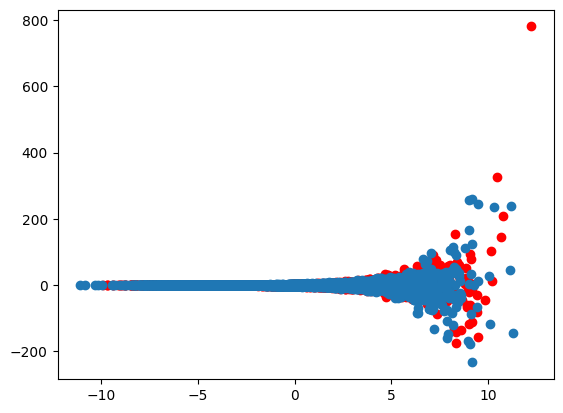

In [9]:
import matplotlib.pyplot as plt
from datasets import FunnelDistribution

dataset = FunnelDistribution(tensor_parameters={})
x, u = dataset.sample_covariates(10000), torch.randn(10000, 1)
y = model.push_u_given_x(u, x)
x_gt, y_gt = dataset.sample_joint(10000)
plt.scatter(x_gt.flatten(), y_gt.flatten(), color='red')
plt.scatter(x.flatten(), y.flatten())
plt.show()

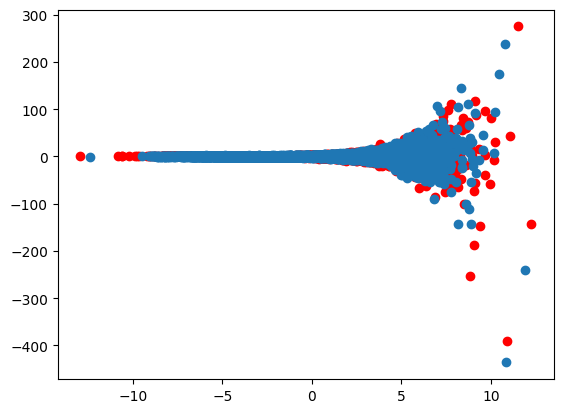

In [9]:
import matplotlib.pyplot as plt
from datasets import FunnelDistribution

dataset = FunnelDistribution(tensor_parameters={})
x, u = dataset.sample_covariates(10000), torch.randn(10000, 1)
y = model.push_u_given_x(u, x)
x_gt, y_gt = dataset.sample_joint(10000)
plt.scatter(x_gt.flatten(), y_gt.flatten(), color='red')
plt.scatter(x.flatten(), y.flatten())
plt.show()

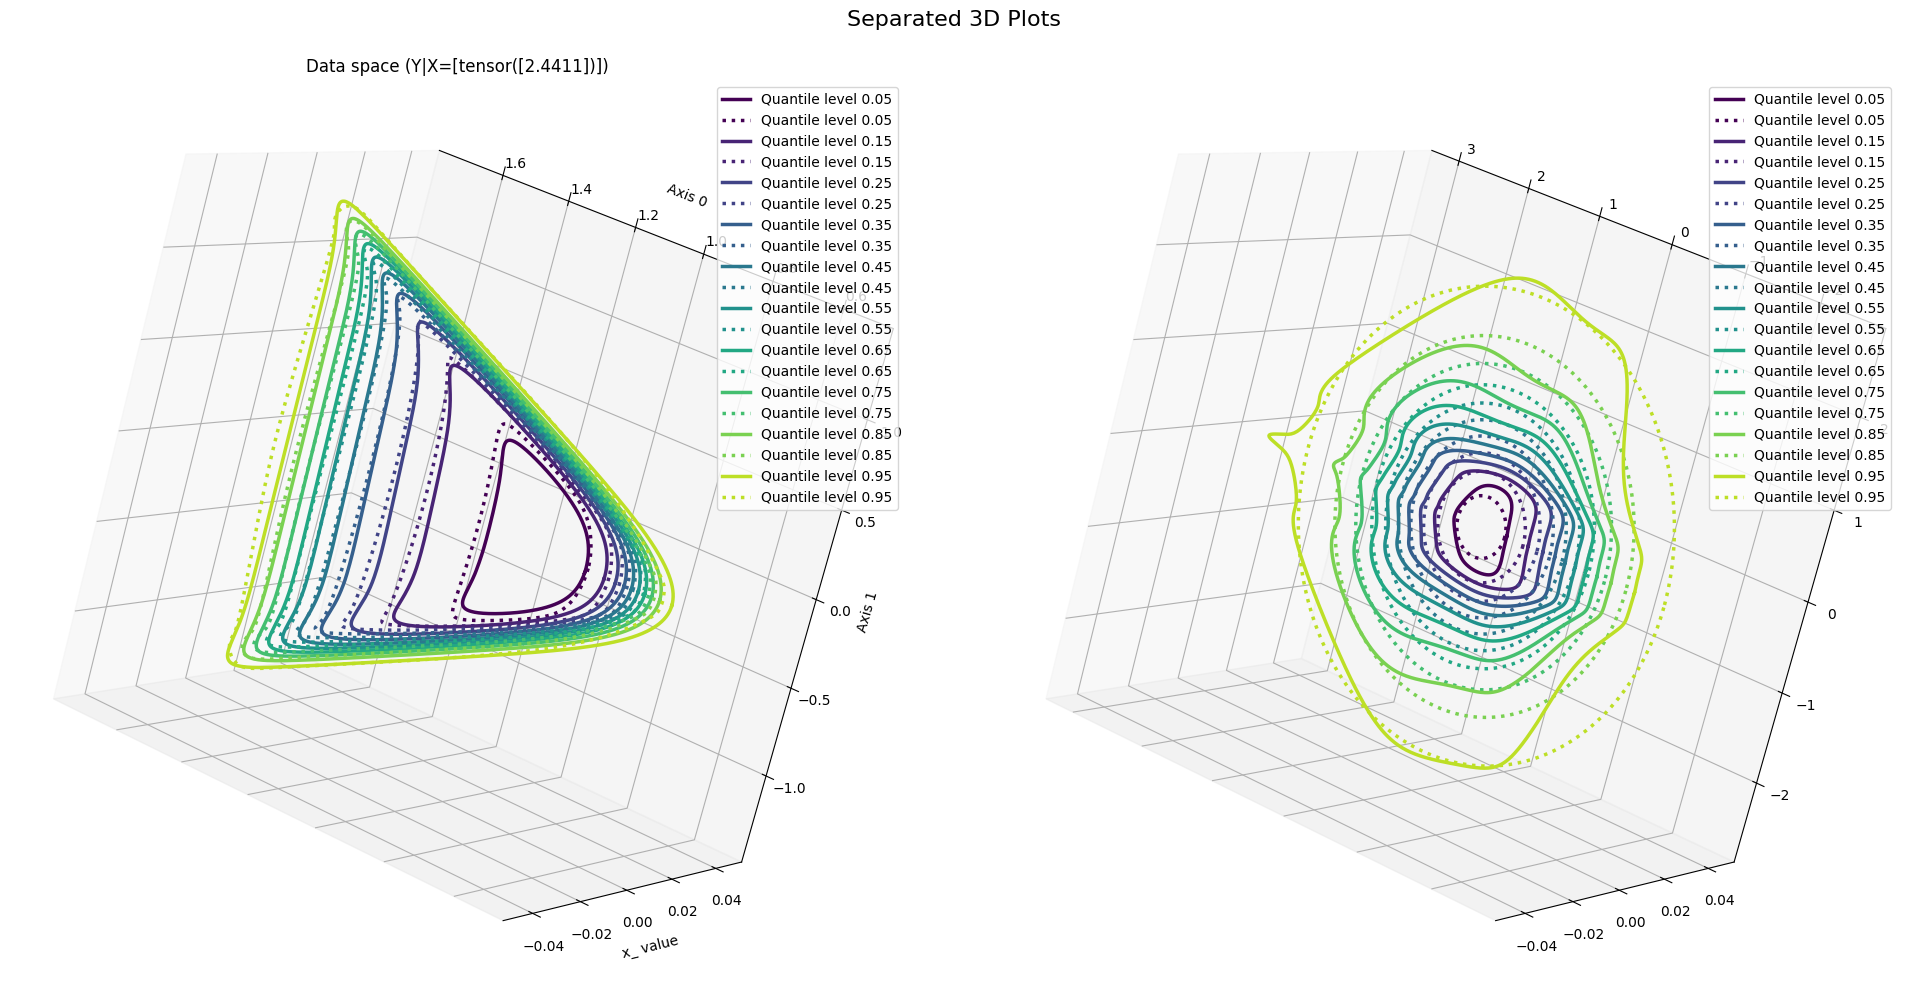

In [8]:
%matplotlib inline
from datasets import PICNN_FNLVQR_Star, PICNN_FNLVQR_Banana
from utils.plot import plot_quantile_levels_from_dataset

dataset = PICNN_FNLVQR_Banana(tensor_parameters=experiment.tensor_parameters)
plot_quantile_levels_from_dataset(
    model=model,
    dataset=dataset,
    conditional_value=dataset.sample_covariates(1),
    number_of_quantile_levels=10,
    tensor_parameters=experiment.tensor_parameters
)